## Milestone project #1: Food Vision Big

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import os 
import pathlib 
import random
import matplotlib.image as mpimg
import zipfile
import wget
import tensorflow_hub as hub
import tensorflow_datasets as tfds

c:\anaconda3\envs\tf2.4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get Helper Functions

In [2]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"


response = requests.get(url)
code = response.text

exec(code)

In [3]:
# import splitfolders
# splitfolders.ratio("food101/images/", output="output", seed=1337, ratio=(.8, 0.1,0.1))

In [4]:
train_dir="output/train/"
test_dir="output/test/"
valid_dir="output/val/"

In [5]:
import pathlib

data_dir = pathlib.Path(train_dir)
class_names=np.array(sorted([item.name for item in data_dir.glob('*')]))

print(class_names,class_names.__len__())

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheese_plate' 'cheesecake' 'chicken_curry'
 'chicken_quesadilla' 'chicken_wings' 'chocolate_cake' 'chocolate_mousse'
 'churros' 'clam_chowder' 'club_sandwich' 'crab_cakes' 'creme_brulee'
 'croque_madame' 'cup_cakes' 'deviled_eggs' 'donuts' 'dumplings' 'edamame'
 'eggs_benedict' 'escargots' 'falafel' 'filet_mignon' 'fish_and_chips'
 'foie_gras' 'french_fries' 'french_onion_soup' 'french_toast'
 'fried_calamari' 'fried_rice' 'frozen_yogurt' 'garlic_bread' 'gnocchi'
 'greek_salad' 'grilled_cheese_sandwich' 'grilled_salmon' 'guacamole'
 'gyoza' 'hamburger' 'hot_and_sour_soup' 'hot_dog' 'huevos_rancheros'
 'hummus' 'ice_cream' 'lasagna' 'lobster_bisque' 'lobster_roll_sandwich'
 'macaroni_and_cheese' 'macarons' 'miso_soup' 'mussels' 'nachos'
 'omelette' 'onion_rings' 'oy

In [6]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               shuffle=True,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )


test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                          shuffle=True,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )

val_data=tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                          shuffle=True,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )

Found 80800 files belonging to 101 classes.
Found 10100 files belonging to 101 classes.
Found 10100 files belonging to 101 classes.


In [7]:
from tensorflow.keras.layers.experimental import preprocessing
# Create data aug

data_augmentation= tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    
],name="data_augmentation")

(-0.5, 408.5, 429.5, -0.5)

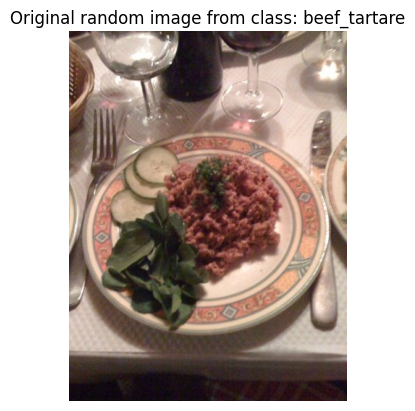

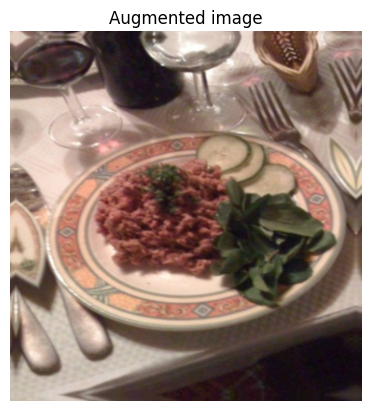

In [8]:
target_class=random.choice(train_data.class_names)

target_dir=train_dir+target_class 

random_image=random.choice(os.listdir(target_dir))

random_image_path=target_dir+"/"+random_image


# Read image 
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)


# Plot augmented random image

augmented_img=data_augmentation(img,training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title("Augmented image")
plt.axis(False)

In [9]:
def preprocess_img(image,label,img_shape=224):
  # image=tf.image.resize(image,[img_shape,img_shape])
  # image=image/255.
  return tf.cast(image,tf.float32),label  
    

In [10]:
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>)

In [12]:
checkpoint_path="model_checkpoints/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_acc",
                                                    save_best_only=True,
                                                    save_weights_only=True,verbose=0)

In [13]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650 SUPER, compute capability 7.5


In [14]:
# Create base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model =>underlying pre-trained patterns aren't updated

base_model.trainable=False

# # Freeze all layers except last 10 

# for layer in base_model.layers[:-10]:
#     layer.trainable=False


# Create inputs into our model

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# # Normalize in case of using (ResNet50v2)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Data augmentation layer
x= data_augmentation(inputs)


x=base_model(x)

# Average the outputs 

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)


# Create the output activation layer

x= tf.keras.layers.Dense(101)(x)
outputs=tf.keras.layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)

# Combine inputs with outputs 

model = tf.keras.Model(inputs,outputs)

In [15]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0     

In [17]:
for layer in model.layers[2].layers:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [18]:
model_history=model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
        validation_data=test_data,
        validation_steps=int(0.15*len(test_data)),
        callbacks=[model_checkpoint]
         )

Epoch 1/5
2525/2525 [==============================] - 993s 273ms/step - loss: 2.2118 - accuracy: 0.4651 - val_loss: 1.5748 - val_accuracy: 0.5904
Epoch 2/5
2525/2525 [==============================] - 931s 255ms/step - loss: 1.7457 - accuracy: 0.5563 - val_loss: 1.4600 - val_accuracy: 0.6223
Epoch 3/5
2525/2525 [==============================] - 911s 249ms/step - loss: 1.6297 - accuracy: 0.5821 - val_loss: 1.4003 - val_accuracy: 0.6303
Epoch 4/5
2525/2525 [==============================] - 990s 276ms/step - loss: 1.5647 - accuracy: 0.5976 - val_loss: 1.3856 - val_accuracy: 0.6376
Epoch 5/5
2525/2525 [==============================] - 911s 245ms/step - loss: 1.5235 - accuracy: 0.6068 - val_loss: 1.3668 - val_accuracy: 0.6416


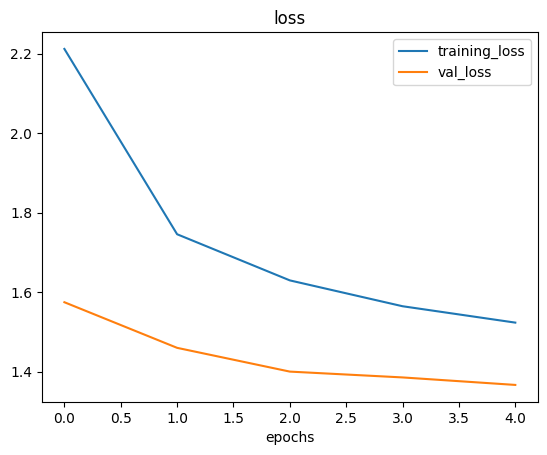

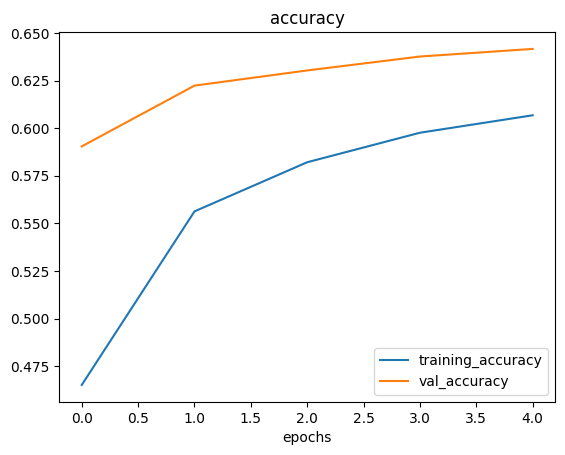

In [19]:
plot_loss_curves(model_history)

In [20]:
model.evaluate(val_data)

316/316 [==============================] - 100s 299ms/step - loss: 1.4142 - accuracy: 0.6349


[1.414239764213562, 0.6348514556884766]